<a href="https://colab.research.google.com/github/mvenouziou/Style_Transfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import IPython.display as display
import numpy as np
from PIL import Image

In [ ]:
# Select Images & Model Parameters

SIZE = (224, 224)
CONTENT_WEIGHT = 10000
STYLE_WEIGHT = 1
NUM_ITER = 1000
LAYERS_WEIGHTS = {#1: 0.2,
                  #4: 0.2,
                  #7: 0.2,
                  12: 0.2,
                  17: 0.2,
                  18: 0.2,
                  }

In [ ]:
# load pre-trained model
# model: ImageNet VGG Very Deep 19

def load_base_model(model='VGG19'):
    # load pre-trained model
    # model: VGG19 or EfficientNetB7

    if model == 'VGG19':
     source_model = \
           tf.keras.applications.VGG19(include_top=False, weights='imagenet', 
                input_tensor=None, input_shape=None, pooling=None, 
                classes=1000, classifier_activation='softmax')
    """
    ##### to do: add more model options here
    """

    source_model.trainable = False  # for transfer learning
    return source_model

source_model = load_base_model()

In [ ]:
source_model.layers

In [ ]:
def view_generated_image(im_array, view=True):
    im_array = im_array.numpy()
    image = \
        tf.keras.preprocessing.image.array_to_img(im_array, data_format=None,
                                                  scale=True, dtype=None)
    if view is True:
        plt.imshow(image)
    return image


def prepare_images(image_content, image_style, size=SIZE):
    """
    # format images as tensors usable by model
    """

    # load images
    content = plt.imread(image_content)
    style = plt.imread(image_style)

    # Resize images
    content = tf.keras.preprocessing.image.smart_resize(content, size)
    style = tf.keras.preprocessing.image.smart_resize(style, size)

    # convert to arrays and standardize
    content = tf.keras.preprocessing.image.img_to_array(content)/255
    style = tf.keras.preprocessing.image.img_to_array(style)/255

    # convert to proper shape: (1, height, width, channels)
    content = tf.expand_dims(content, axis=0)
    style = tf.expand_dims(style, axis=0)

    return content, style


def initialize_generated_image(input_image, noise_rate):
    noise = tf.random.uniform(shape=input_image.shape, minval=-20, maxval=20)
    image = noise * noise_rate + input_image * (1 - noise_rate)
    return image

In [ ]:
### Cost Functions
# Difference between input image and generated
# Difference between style image and generated

In [ ]:
### Cost Functions
# Difference between input image and generated
# Difference between style image and generated

def content_cost(image_activations, generated_activations, content_layer):

    # select content data
    image = image_activations[content_layer]
    generated = generated_activations[content_layer]

    # compute scale factor
    height = image.shape[-3]
    width = image.shape[-2]
    num_channels = image.shape[-1]
    scale_factor = 1 / (4 * height * width * num_channels)

    # compute cost
    cost = scale_factor * tf.norm(tensor= image - generated, ord='euclidean')

    return cost


def gram_matrix(image):
    """
    Computes Gram Matrix
    Parameter:
    image: tensors of shape (px_width, px_height, channels)
    """
    num_channels = image.shape[-1]
    image = tf.reshape(image, [-1, num_channels])
    gram = tf.linalg.matmul(image, image, transpose_a=True, transpose_b=False)
    return gram


def style_cost(style_activations, generated_activations, weights):

    # initialize cost
    cost = 0

    for layer in style_activations.keys():
        # select content data
        style = style_activations[layer]
        generated = generated_activations[layer]
        weight = weights[layer]

        # compute scale factor
        height = style.shape[-3]
        width = style.shape[-2]
        num_channels = style.shape[-1]
        scale_factor = 1 / (4 * (height**2) * (width**2) * (num_channels**2))

       # compute cost
        gram_style = gram_matrix(style)
        gram_generated = gram_matrix(generated)

        cost += weight * scale_factor * tf.norm(gram_style - gram_generated, ord=2)**2

    return cost

In [ ]:

def learn_activations(input_tensor, orig_model, layers_list):
    """
    Conducts forward pass of given model and stores activations
    indicated by layers list.
    """

    # initialize activations container
    activations_computed = dict()
    num_layers = len(orig_model.layers)  # number of activations to record
    layers_list = [1] + layers_list  # adjustment for better looping

    # forward pass

    x = orig_model.layers[1](input_tensor)

    for k in range(1, len(layers_list)):
        for i in range(layers_list[k - 1] + 1, layers_list[k] + 1):
            x = orig_model.layers[i](x)
        # store activation
        activations_computed[layers_list[k]] = x

    #for i in range(layers_list[-1] + 1, num_layers):  # final step
    #    x = orig_model.layers[i](x)
    #activations_computed['output'] = x

    return activations_computed


In [ ]:
def train_generated_image(init_generated_image, image_activations, 
                          style_activations, cnn_model, layers_dict, 
                          content_weight, style_weight, num_iterations):

    computed_images_dict = dict()

    # show original image
    print('Original image:\n')
    temp_image = tf.convert_to_tensor(init_generated_image * 255)
    temp_image = tf.squeeze(temp_image)
    display.clear_output(wait=True)
    display.display(view_generated_image(temp_image, False))

    # get parameters
    layers = list(layers_dict.keys())  # lists of CNN layer numbers
    content_layer = list(layers_dict.keys())[-1]

    # initialize variables
    learned_im = tf.Variable(init_generated_image)

    # set optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.9, 
                                         beta_2=0.999, epsilon=1e-1, 
                                         amsgrad=False, name='Adam')

    for iter in range(1, num_iterations + 1):
        with tf.GradientTape() as tape:
            tape.watch(learned_im)

            def loss_function():
                generated_activations = \
                    learn_activations(learned_im, cnn_model, layers)
                # compute loss
                loss = content_weight * content_cost(image_activations, 
                                                     generated_activations, 
                                                     content_layer) + \
                        style_weight * style_cost(style_activations, 
                                                  generated_activations, 
                                                  layers_dict)
                return loss

        # apply gradients
        optimizer.minimize(loss=loss_function, var_list=[learned_im])
        learned_im = \
            tf.clip_by_value(learned_im, clip_value_min=0.0, clip_value_max=1.0)
        learned_im = tf.Variable(learned_im)

        # give status updates
        if iter % 100 == 0:
            print("iteration:", iter)
            print("loss:", loss_function().numpy())
            # save image to dictionary
            computed_images_dict[iter] = learned_im
            
            if iter % 200 == 0:
                learned_image = tf.convert_to_tensor(learned_im * 255)
                learned_image = tf.squeeze(learned_image)
                display.clear_output(wait=True)
                display.display(view_generated_image(learned_image, False))
                
    print("Completed.")
    print("loss:", loss_function().numpy())

    learned_image = tf.convert_to_tensor(learned_im * 255)
    learned_image = tf.squeeze(learned_image)

    return learned_image, computed_images_dict


In [ ]:
def style_transfer(image_content, image_style, layers_dict=LAYERS_WEIGHTS, *kargs):

    print('Note: Generated image may take time to converge)\n' +
       'Use of GPU is highly recommended')

    # prepare images
    image_tensor, style_tensor = prepare_images(image_content, image_style)

    init_generated_image = \
        initialize_generated_image(image_tensor, noise_rate=.01)
    init_generated_image = tf.convert_to_tensor(init_generated_image)

    # prepare model parameters
    image_model = load_base_model()  # pre-trained image processing CNN
    layers = list(layers_dict.keys())  # lists CNN layer numbers for transfer
    image_activations = learn_activations(image_tensor, image_model, layers)
    style_activations = learn_activations(style_tensor, image_model, layers)

    # style transfer model
    G_new, computed_images_dict = \
        train_generated_image(init_generated_image, image_activations, 
                              style_activations, image_model, layers_dict, 
                              content_weight=CONTENT_WEIGHT, 
                              style_weight=STYLE_WEIGHT, num_iterations=NUM_ITER)

    return G_new, computed_images_dict

In [ ]:
# Load images options
# original image 
true_image_path = ''
true_image_2_path = ''

# style options
style_image_path = ''
style_image_2_path = ''
style_image_3_path = ''
style_image_4_path = ''



true_image_path = tf.keras.utils.get_file('josh-hild-RD0BXCGemEY-unsplash.jpg', 'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/josh-hild-RD0BXCGemEY-unsplash.jpg')
true_image_2_path = tf.keras.utils.get_file('brandon-mowinkel-UGi_Ng56FRI-unsplash.jpg', 'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/brandon-mowinkel-UGi_Ng56FRI-unsplash.jpg')

style_image_path = tf.keras.utils.get_file('autumn-studio-PaM7SD5wM6g-unsplash.jpg', 'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/autumn-studio-PaM7SD5wM6g-unsplash.jpg')
style_image_2_path = tf.keras.utils.get_file('aida-batres-_QxzSVWesm0-unsplash.jpg', 'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/aida-batres-_QxzSVWesm0-unsplash.jpg')
style_image_3_path = tf.keras.utils.get_file('pawel-czerwinski-g2Zf3hJyYAc-unsplash.jpg', 'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/pawel-czerwinski-g2Zf3hJyYAc-unsplash.jpg')
style_image_4_path = tf.keras.utils.get_file('lucas-sankey-gdQ_az6CSPo-unsplash.jpg', 'https://raw.githubusercontent.com/mvenouziou/Style_Transfer/master/lucas-sankey-gdQ_az6CSPo-unsplash.jpg')

65536/61296 [================================] - 0s 0us/step


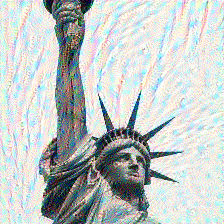

Completed.
loss: 13.656391


In [ ]:
# select images and run program


#-- for custom images on Google Drive
# from google.colab import drive
# drive.mount('/content/drive')


# Public image datasets from tensorflow-datasets
#import tensorflow_datasets as tfds
#style_image_library = tfds.load('shapes3d', try_gcs=True, download=False)
#style_image = style_image_library.take(1)['image']

#true_image_library = tfds.load('vgg_face2', try_gcs=True, download=False)
#true_image = style_image_library.take(1)['image']
# assert isinstance(mnist_train, tf.data.Dataset)

true = true_image_2_path
style = style_image_3_path

# Run program
image, itermediary_images = \
    style_transfer(true, style, layers_dict=LAYERS_WEIGHTS)

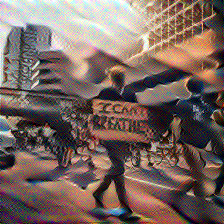

In [ ]:
display.display(view_generated_image(image, False))

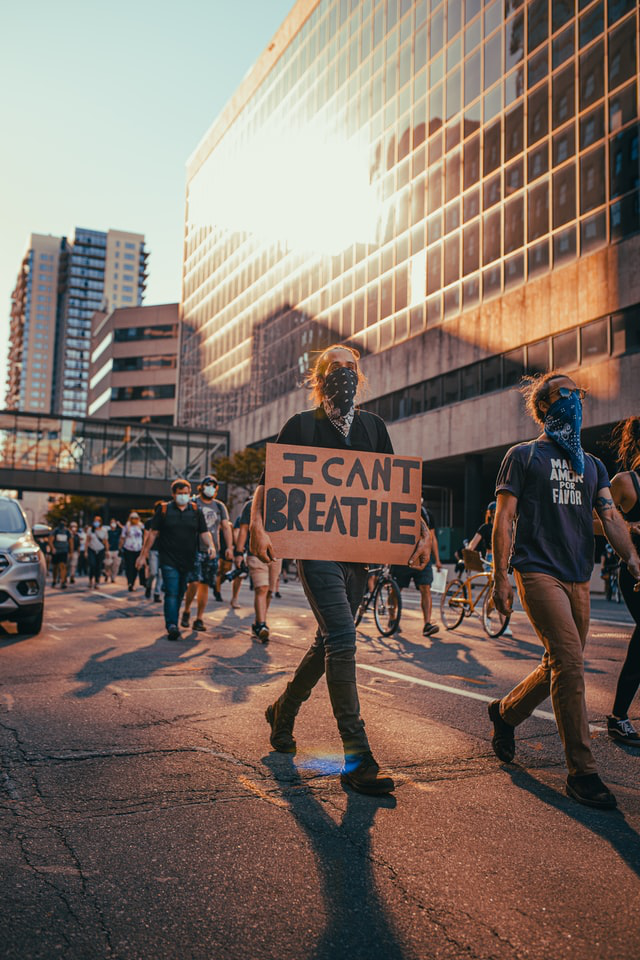

In [ ]:
# original image
Image.open(true)

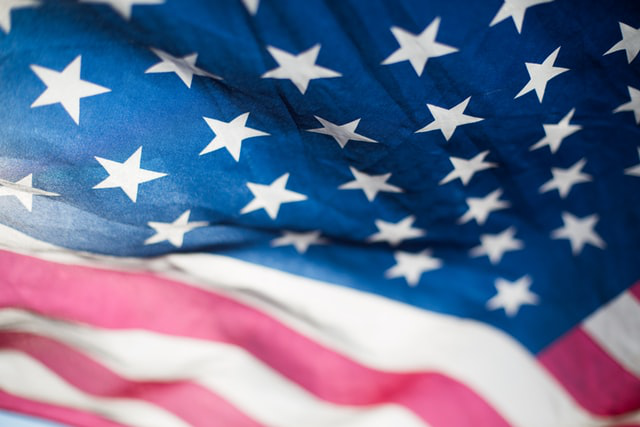

In [ ]:
# style image
Image.open(style)